# AmBe Experimental Unfold

This notebook describes the HEPROW unfold steps for a truncated AmBe spectrum.  The setup was where the PHS data is all neutrons emitted in coincidence with a 4.4 MeV gamma.  This data waas taken to compare the unfolding algorithms to a known TOF spectrum.  The bulk of the data and experiment was analyzed by Matt Harasty, and is documented elsewhere. 

This notebook is broken into the following sections: <br\>
1) Calibration of PHS <br\>
2) Response Matrix Generation <br\>
3) HEPROW Unfold <br\>
4) NSD Unfold <br\>
5) Results <br\>

Root must be installed and PyRoot enabled for this notebook to work.

First, load the necessary libraries, set the appropriate environment variables, and compile the C++ support macros from the instructions @ https://bitbucket.org/berkeleylab/nsd-rootscripts/wiki/LibraryCompilation.

Load python dependencies:

In [1]:
from ROOT import gROOT
import numpy as np

gROOT.ProcessLine('HistogramWriter writer;')
gROOT.ProcessLine('HistogramOperations ops;')

47006053830704L

## PHS Calibration

### User inputs

dataPath = the absolute location of where the root files are located <br/>
phsName = file name for the pulse height spectra TTree <br/>
outPath = the absolute path of where to place the generated HEPROW input files

In [2]:
dataPath="/home/pyne-user/Dropbox/UCB/Research/ETAs/88Inch/Data/"
phsName="Experiments/PHS/AmBe/Data/AmBePhEn7and16Combined.root"
outPath="/home/pyne-user/Dropbox/UCB/Research/ETAs/88Inch/Data/Experiments/PHS/AmBe/Unfold/250keV/Inputs/"

### Load PHS Data File

In [3]:
gROOT.ProcessLine('TFile f("{}")'.format(dataPath+phsName))

47470280773728L

### Apply Calibration and print the .phs file

The calibration was done elsewhere by Matthew Harasty.  The calibration parameters found were:

S = 1 <br\>
kb = 6.994 <br\> 
a = 6.12038e-05 <br\>
b = 0.0205843 <br\>
Ec  = 0.084756 <br\>
E1 = 0.0181084 <br\>
E2 = 0.0442753 <br\>

In [4]:
gROOT.ProcessLine('ops.applyCalibration(bothPh, 6.12038e-05 ,0.0205843);')

0L

In [5]:
gROOT.ProcessLine('bothPh->Draw()')

0L

Truncate all negative and all zeros data.  This is necessary for unfolding in HEPROW.

Find the first bin with data.  The cell will print the first bin, but not the lower MeVee edge.  It is a bit clunky, but you can read it directly from the terminal running this notebook (or run the commands in Root directly).

In [6]:
gROOT.ProcessLine('tmpSpectrum = (TH1D*)ops.truncateHist(bothPh,0.06,4.5);')

i=0
while gROOT.ProcessLine('tmpSpectrum->GetBinContent({})'.format(i))==0:
    i+=1
print i

gROOT.ProcessLine('tmpSpectrum->GetXaxis()->GetBinLowEdge({})'.format(i))

2


0L

Choose a rebin number to get the desired MeVee/bin.  In this case, 1 was chosen to get ~ 0.01 MeVee/bin 

In [7]:
rebin=1
gROOT.ProcessLine('PulseHeightSpectrum = (TH1D*)ops.truncateHist(tmpSpectrum,6.648715e-02,4.5);')
gROOT.ProcessLine('PulseHeightSpectrum->Rebin({})'.format(rebin))
gROOT.ProcessLine('PulseHeightSpectrum->GetXaxis()->GetBinLowEdge({})'.format(0))
gROOT.ProcessLine('PulseHeightSpectrum->Draw()')

0L

Print out the .phs file for both statistic bins and the intrinsic rebin from above:

In [8]:
gROOT.ProcessLine('TH1* dataHist = ops.rebinStatistically(PulseHeightSpectrum,100);')
gROOT.ProcessLine('writer.PhToHEPROW(PulseHeightSpectrum,"{}phs_01")'.format(outPath))
gROOT.ProcessLine('writer.PhToHEPROW(dataHist,"{}stat_100_phs_01")'.format(outPath))

0L

## Response Matrix

### Response Matrix Inputs

rspName = file name for the response matrix TTree <br/>

rspEwidth = the width of bins to use for the binning of the response matrix energy <br/>
rspEmin = the minimum Energy to use for the binning of the response matrix  <br/>
rspEmax = the maximum Energy to use for the binning of the response matrix  <br/>
rspLwidth = the width of bins to use for the binning of the response matrix light <br/>
rspLmin = the minimum Light to use for the binning of the response matrix  <br/>
rspLmax = the maximum Light to use for the binning of the response matrix  <br/>

In [3]:
rspName="Simulated/PHS/ResponseMatrices/simFrontResponse20Mil.root"

rspEwidth=0.25
rspEmin=0.5
rspEmax=8.0
rspLwidth=0.01
rspLmin=0.0
rspLmax=4.0

### Load Response Matrix Data File

In [4]:
gROOT.ProcessLine('SimulationManipulation sm("{}",0)'.format(dataPath+rspName))

47006053830752L

### Create the bin structures and print .rsp file

In [5]:
# Create the bin structures
rspEbins=np.arange(rspEmin,rspEmax,rspEwidth)
rspEbins=np.append(rspEbins,rspEmax)
#print rspEbins
rspLbins=np.arange(rspLmin,rspLmax,rspLwidth)
rspLbins=np.append(rspLbins,rspLmax)
#print rspLbins
gROOT.ProcessLine('const Int_t EBINS = {}; const Int_t LBINS = {};'.format(len(rspEbins)-1,len(rspLbins)-1))
gROOT.ProcessLine('Double_t eEdges[EBINS + 1] = {}{}{};'.format("{",", ".join(str(e) for e in rspEbins),"}"))
gROOT.ProcessLine('Double_t lEdges[LBINS + 1] = {}{}{};'.format("{",", ".join(str(e) for e in rspLbins),"}"))
gROOT.ProcessLine('axis1 = TAxis(EBINS,eEdges);')
gROOT.ProcessLine('axis2 = TAxis(LBINS,lEdges);')

# Create the Histogram and output file
gROOT.ProcessLine('TH2* hist=sm.getNormalizedResponseMatrix(axis1,axis2)')
gROOT.ProcessLine('hist->Draw("colz")')
gROOT.ProcessLine('writer.ResponseToHEPROW(hist,"{}resp_01_250")'.format(outPath))

0L

### Smear the Response Matrix and Create the .rsp File

In [6]:
gROOT.ProcessLine('TH2* smearHist2 = ops.skewedGausSmearMatrix(hist,0.084756,0.0181084,0.0442753)')
gROOT.ProcessLine('smearHist2->Draw("colz")')
gROOT.ProcessLine('writer.ResponseToHEPROW(smearHist2,"{}smearedResp_01_250")'.format(outPath))

0L

## HEPROW Unfold

The actually running of HEPROW is done separately through the Windows executables.  The location for the files is: <br\>

/home/pyne-user/Dropbox/UCB/Research/ETAs/88Inch/Data/Experiments/PHS/16MeVBe/Unfold/HEPROW

### Mik.inp Support

These lines are useful to develop the mik.inp file:

In [9]:
bounds = np.linspace(0.5,rspEmax-0.25,len(rspEbins)-1)   #(First right bin boundary, last right bin, boundary, number of bins)
print len(bounds)
for i in range(0,len(bounds)):
    print '{}                                      right boundary of energy interval {}'.format(bounds[i],i+1)

30
0.5                                      right boundary of energy interval 1
0.75                                      right boundary of energy interval 2
1.0                                      right boundary of energy interval 3
1.25                                      right boundary of energy interval 4
1.5                                      right boundary of energy interval 5
1.75                                      right boundary of energy interval 6
2.0                                      right boundary of energy interval 7
2.25                                      right boundary of energy interval 8
2.5                                      right boundary of energy interval 9
2.75                                      right boundary of energy interval 10
3.0                                      right boundary of energy interval 11
3.25                                      right boundary of energy interval 12
3.5                                      right boundary of energ

## Results

This section contains all of the output post-processing to end up with a plot of the spectrum.

In [10]:
import sys
import os

import pandas as pd
import numpy as np

from datetime import datetime

%matplotlib inline

# Path to support scripts 
sys.path.insert(0,os.path.abspath('/home/pyne-user/Dropbox/UCB/Computational_Tools/Scripts/Python/DataAnalysis'))
from DataManipulation import bin_differentiation, normAUBC
from DataIO import read_delimited_data_file
from Histograms import Histogram

sys.path.insert(0,os.path.abspath('/home/pyne-user/Dropbox/UCB/Computational_Tools/Scripts/Python/Unfolding'))
from HEPROW import readMTX, readGru, readFlu

### Set Data Locations

In [12]:
# HEPROW Inputs:
heprowPath = "/home/pyne-user/Dropbox/UCB/Research/ETAs/88Inch/Data/Experiments/PHS/AmBe/Unfold/250keV/"

heprowName = "mik.gru"
unfanaName = "unf.gru"
gravelName = "grv_out.flu"
faltwPHSName = "faltw.phs"
measPHSName = "Inputs/stat_100_phs_01.phs"
mtxName = "MIEKE.MTX"
heprowBinBounds = "low"

# Output
outPath="/home/pyne-user/Dropbox/UCB/Research/ETAs/88Inch/Data/Experiments/PHS/AmBe/Unfold/"

### Read in and Manipulate Data

Convert Each Data Set to a Probability Density Function (PDF), calculate error for PDF, and normalize the abs spectrum.

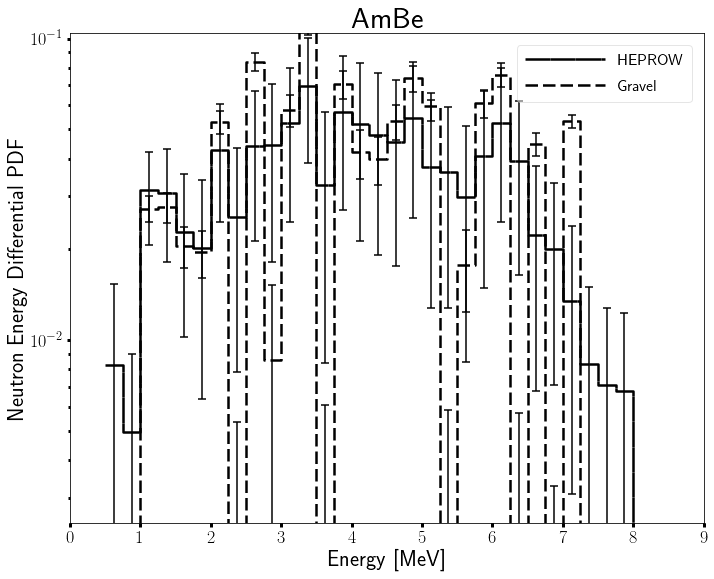

In [30]:
# Import HEPROW, UNFANA, and Gravel data and normalize
heprowData = readGru(heprowPath+heprowName, delim_whitespace=True, names=['lowE', 'absFlux', 'absSigma'],
               skiprows=3)
heprowData['absSigma'] = readMTX(heprowPath+mtxName).tolist()
heprowData['absFlux'] = np.asarray(bin_differentiation(heprowData['lowE'].tolist(), 
                                            heprowData['absFlux'].tolist(), heprowBinBounds))
heprowData['absSigma'] = np.asarray(bin_differentiation(heprowData['lowE'].tolist(), 
                                            heprowData['absSigma'].tolist(), heprowBinBounds))
        
unfData = readGru(heprowPath+unfanaName, delim_whitespace=True, names=['lowE', 'absFlux', 'absSigma'],
               skiprows=3)
unfData['absSigma'] = readMTX(heprowPath+mtxName).tolist()
unfData['absFlux'] = np.asarray(bin_differentiation(unfData['lowE'].tolist(), 
                                            unfData['absFlux'].tolist(), heprowBinBounds))
unfData['absSigma'] = np.asarray(bin_differentiation(unfData['lowE'].tolist(), 
                                            unfData['absSigma'].tolist(), heprowBinBounds))
        
grvData = readFlu(heprowPath+gravelName, delim_whitespace=True, names=['lowE', 'absFlux', 'absSigma'],
               skiprows=3)
grvData['absSigma'] = readMTX(heprowPath+mtxName).tolist()
grvData['absFlux'] = np.asarray(bin_differentiation(grvData['lowE'].tolist(), 
                                            grvData['absFlux'].tolist(), heprowBinBounds))
grvData['absSigma'] = np.asarray(bin_differentiation(grvData['lowE'].tolist(), 
                                            grvData['absSigma'].tolist(), heprowBinBounds))

# Calculate the pdf and its uncertainty
heprowData['pdfFlux'] = normAUBC(heprowData['absFlux'])
heprowData['pdfSigma'] = heprowData['absSigma']/heprowData['absFlux']*heprowData['pdfFlux']

unfData['pdfFlux'] = normAUBC(unfData['absFlux'])
unfData['pdfSigma'] = unfData['absSigma']/unfData['absFlux']*unfData['pdfFlux']

grvData['pdfFlux'] = normAUBC(grvData['absFlux'])
grvData['pdfSigma'] = grvData['absSigma']/grvData['absFlux']*grvData['pdfFlux']

# Build pdf histogram object
heprowHisto = Histogram()
heprowHisto.build_histo(heprowData['lowE'].tolist(), heprowData['pdfFlux'].tolist(),
                       uncert=heprowData['pdfSigma'].tolist(), edgeLoc=heprowBinBounds,
                       name='HEPROW')
unfHisto = Histogram()
unfHisto.build_histo(unfData['lowE'].tolist(), unfData['pdfFlux'].tolist(),
                       uncert=unfData['pdfSigma'].tolist(), edgeLoc=heprowBinBounds,
                       name='UNFANA')
grvHisto = Histogram()
grvHisto.build_histo(grvData['lowE'].tolist(), grvData['pdfFlux'].tolist(),
                       uncert=grvData['pdfSigma'].tolist(), edgeLoc=heprowBinBounds,
                       name='Gravel')
heprowHisto.plot(grvHisto,logY=True, title='AmBe', xLabel='Energy [MeV]',
                 yLabel='Neutron Energy Differential PDF')
heprowHisto.write(outPath+'AmBe_pdf_250keV', includeUncert=True, edge=False)

# Build abs histogram object
heprowAbsHisto = Histogram()
heprowAbsHisto.build_histo(heprowData['lowE'].tolist(), heprowData['absFlux'].tolist(),
                       uncert=heprowData['absSigma'].tolist(), edgeLoc=heprowBinBounds,
                       name='HEPROW')
heprowAbsHisto.write(outPath+'AmBe_abs_250keV', includeUncert=True, edge=False)

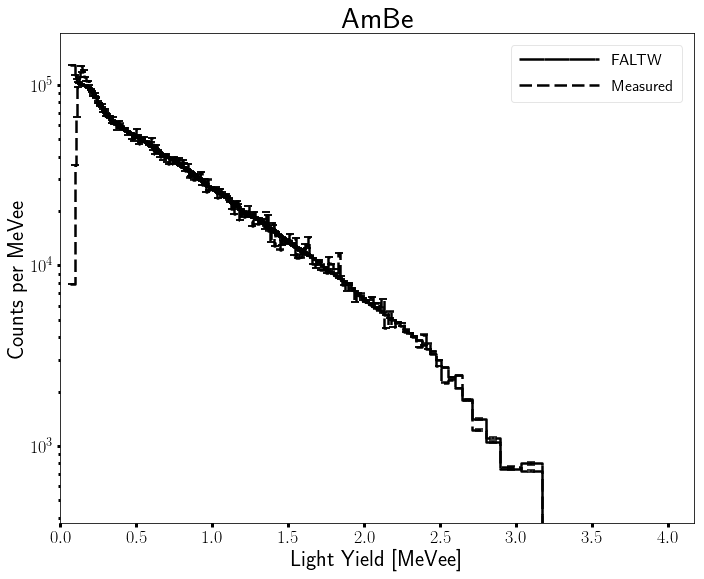

In [31]:
# Import PHS data and plot
faltwPHSData = readFlu(heprowPath+faltwPHSName, delim_whitespace=True, names=['lowE', 'absPHS', 'absSigma'],
               skiprows=3)
measPHSData = readFlu(heprowPath+measPHSName, delim_whitespace=True, names=['lowE', 'absPHS', 'absSigma'],
               skiprows=3)
faltwPHSHisto = Histogram()
faltwPHSHisto.build_histo(faltwPHSData['lowE'].tolist(), 
                         bin_differentiation(faltwPHSData['lowE'].tolist(),
                                             faltwPHSData['absPHS'].tolist()),
                       uncert=faltwPHSData['absSigma'].tolist(), edgeLoc=heprowBinBounds,
                       name='FALTW')
measPHSHisto = Histogram()
measPHSHisto.build_histo(measPHSData['lowE'].tolist(), 
                         bin_differentiation(measPHSData['lowE'].tolist(),
                                             measPHSData['absPHS'].tolist()),
                         uncert=measPHSData['absSigma'].tolist(), edgeLoc=heprowBinBounds,
                         name='Measured')
faltwPHSHisto.plot(measPHSHisto, logY=True, title='AmBe', xLabel='Light Yield [MeVee]',
                 yLabel='Counts per MeVee')

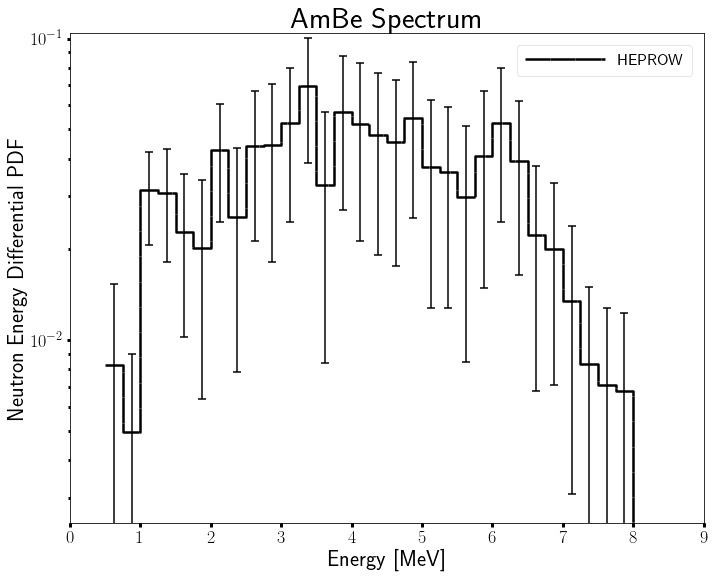

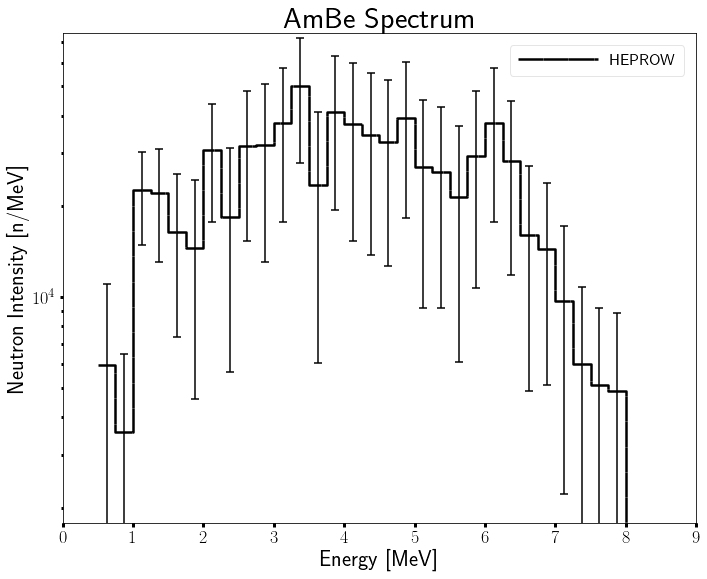

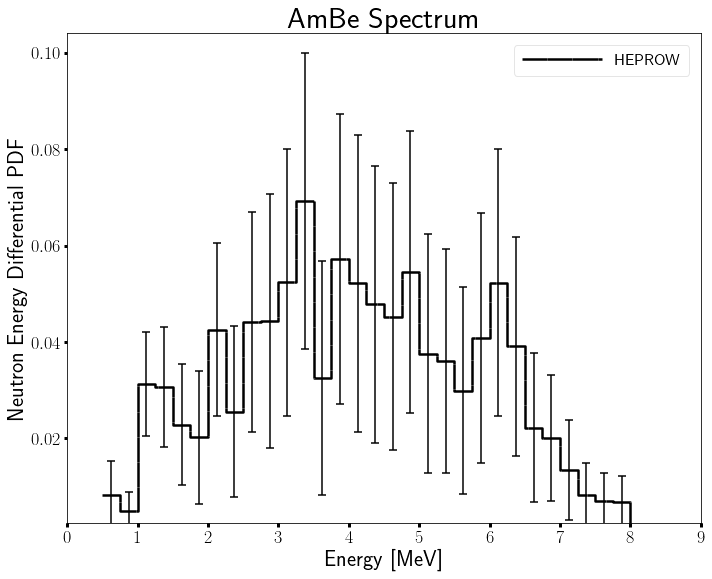

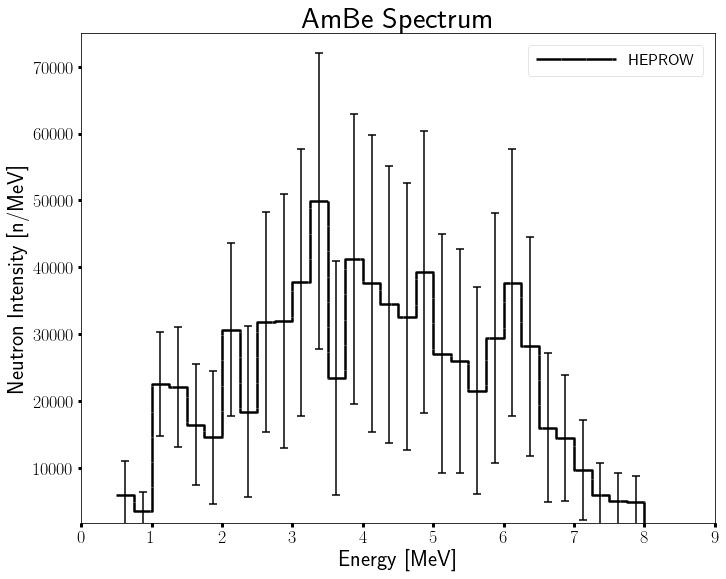

In [32]:
# Log
heprowHisto.plot(logY=True, title='AmBe Spectrum', xLabel='Energy [MeV]', 
                 yLabel='Neutron Energy Differential PDF', savePath=outPath+'AmBe_pdf_log_250keV')
heprowAbsHisto.plot(logY=True, title='AmBe Spectrum', xLabel='Energy [MeV]', 
                    yLabel='Neutron Intensity [n/MeV]', savePath=outPath+'AmBe_abs_log_250keV')

# Linear
heprowHisto.plot(title='AmBe Spectrum', xLabel='Energy [MeV]',
                 yLabel='Neutron Energy Differential PDF', savePath=outPath+'AmBe_pdf_lin_250keV')
heprowAbsHisto.plot(title='AmBe Spectrum', xLabel='Energy [MeV]', 
                     yLabel='Neutron Intensity [n/MeV]', savePath=outPath+'AmBe_abs_lin_250keV')